In [135]:
#Initialization

import importlib

from platform import python_version
import tensorflow as tf
import librosa as lb
import audiomentations as augs
import functools
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict
import soundfile as sf
import random
from pathlib import Path
import os

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import data_preprocessing as dpp
importlib.reload(dpp)




import warnings
warnings.filterwarnings("ignore") #ignore warnings

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('Librosa Version          : ', lb.__version__)
print('Audiomentations Version  : ', augs.__version__)

Python Version           :  3.10.12
TensorFlow Version       :  2.17.0
Librosa Version          :  0.10.2.post1
Audiomentations Version  :  0.37.0


# Train New Model to Handle Low Quality

> Author: Regina Arissaputri (223740481)

> Date: 24th November 2024 

In this report, we train the model to take and classify low quality data

As was mentioned in the previous report, the model is not able to classify downsampled data, thus we can infer that the model sees the low quality data as a completely new data. Thus we need to train the model to take low quality data instead, as the goal of this section is to get the minimum data size while also getting decent accuracy.

## 4000Hz Downsampled Data

In [136]:
# update SC
SC = dpp.update_global_config({'AUDIO_DATA_DIRECTORY4000': "C:/Users/regin/Documents/SIT374/new_data4000", #new dataset location.,
                             'AUDIO_SAMPLE_RATE': 4000,
                             'AUDIO_NFFT': 256,
                             'AUDIO_STRIDE': 50,
                             'AUDIO_MELS': 128,
                             'AUDIO_FMAX': 2000,
                             'AUDIO_TOP_DB': 60,
                            })

### File Checking

First, we need to check the files of the audio data that we have. 

In [137]:
# labels, class_names = dpp.species_list(config.SC['AUDIO_DATA_DIRECTORY'])

print(f" labels: {dpp.labels}")
print(f"class_names: {dpp.class_names}")
print(f"Number of classes: {len(dpp.class_names)}")

 labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

### Preprocessing
Here we preprocess the data into mel spectrograph images.

But before that, we make a tensorflow dataset that contains the class names and file paths.

In [138]:
ds4000 = dpp.create_datasets(SC['AUDIO_DATA_DIRECTORY4000'], dpp.class_names, samples = 1000)

print(f"Number of samples: {len(ds4000)}")
print(f"print labels from dataset with 4000Hz {ds4000}")

Number of samples: 7514
print labels from test_ds <_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(118,), dtype=tf.float32, name=None))>


In [139]:
# Apply the split
train_ds4000, val_ds4000, test_ds4000 = dpp.split_dataset(ds4000, 0.7, 0.2, 0.1)

print(f"Training Samples: {len(train_ds4000)}")
print(f"Validation Samples: {len(val_ds4000)}")
print(f"Testing Samples: {len(test_ds4000)}")

Training Samples: 5259
Validation Samples: 1502
Testing Samples: 753


The code below will convert the audio data to mel spectrograph and ensure that the data is in the correct format to input into the model. 

#### Data Generation Pipeline

In [140]:

# Get the length of the training dataset
train_ds = len(train_ds4000)
parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32)
procs_output_types = (tf.float32,tf.float32)

# Create the training dataset pipeline
train4000 = (train_ds4000
            .shuffle(train_ds)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            # .map(functools.partial(python_function_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

# Create the validation dataset pipeline
val4000 = (val_ds4000
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

# Create the test dataset pipeline
test4000 = (test_ds4000
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

Let's check the pipeline for now, the blank area is due to padding, because we want 5 seconds audio.

 sample info: (16, 260, 260, 3), 
 label info: (16, 118) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


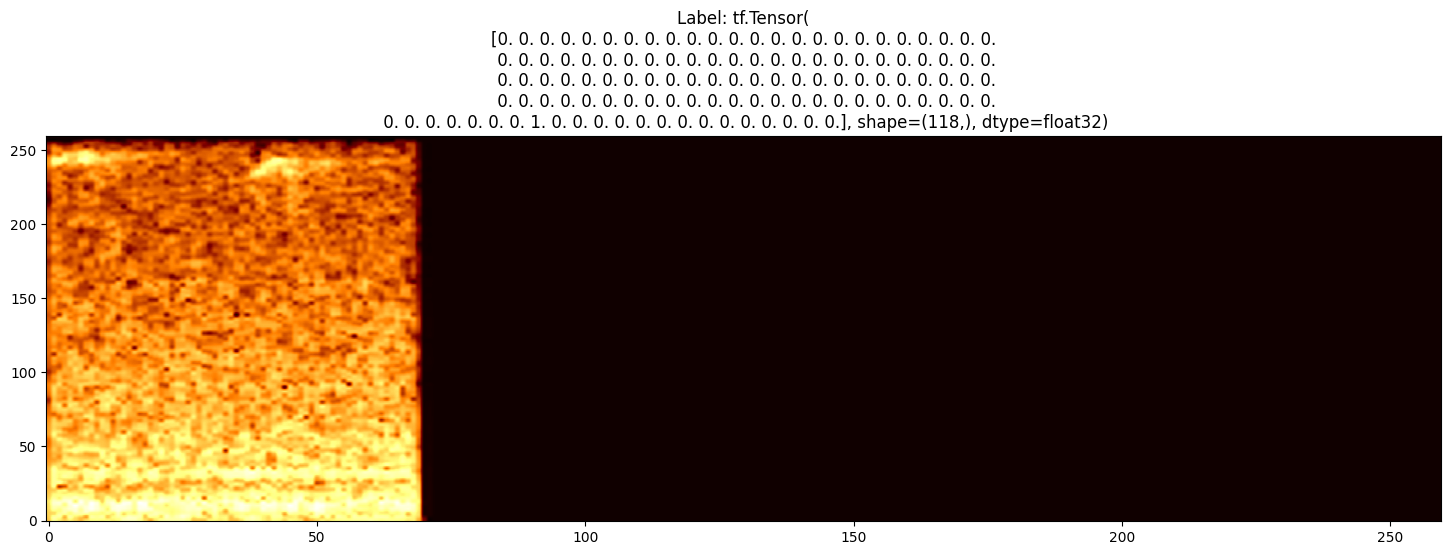

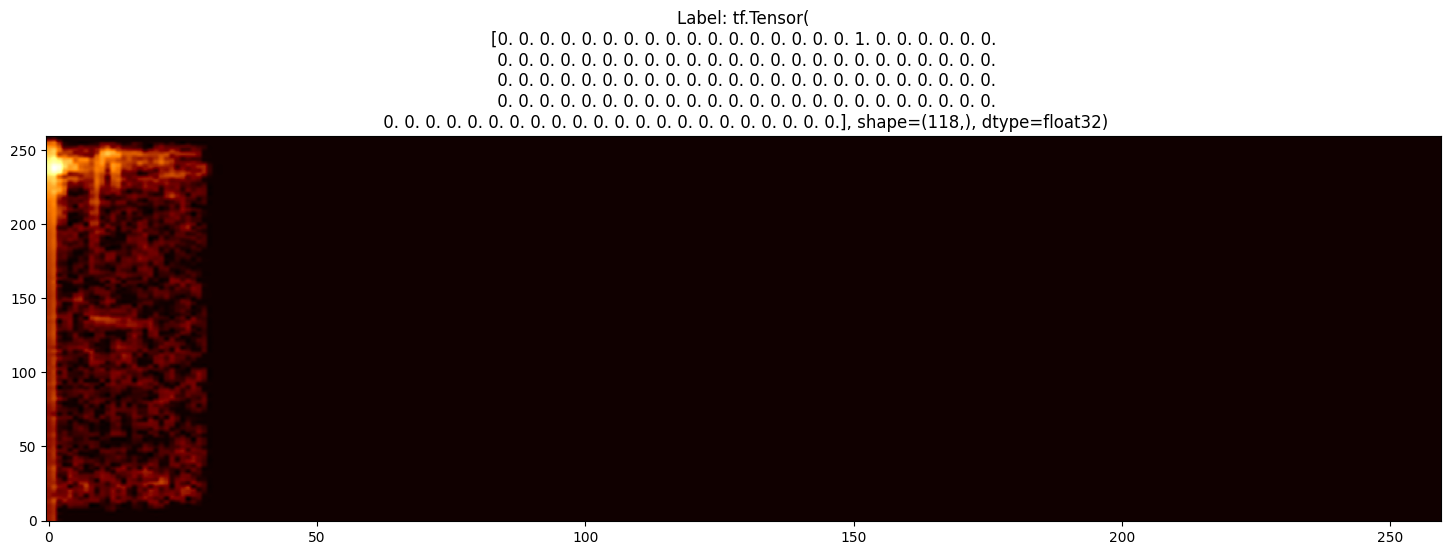

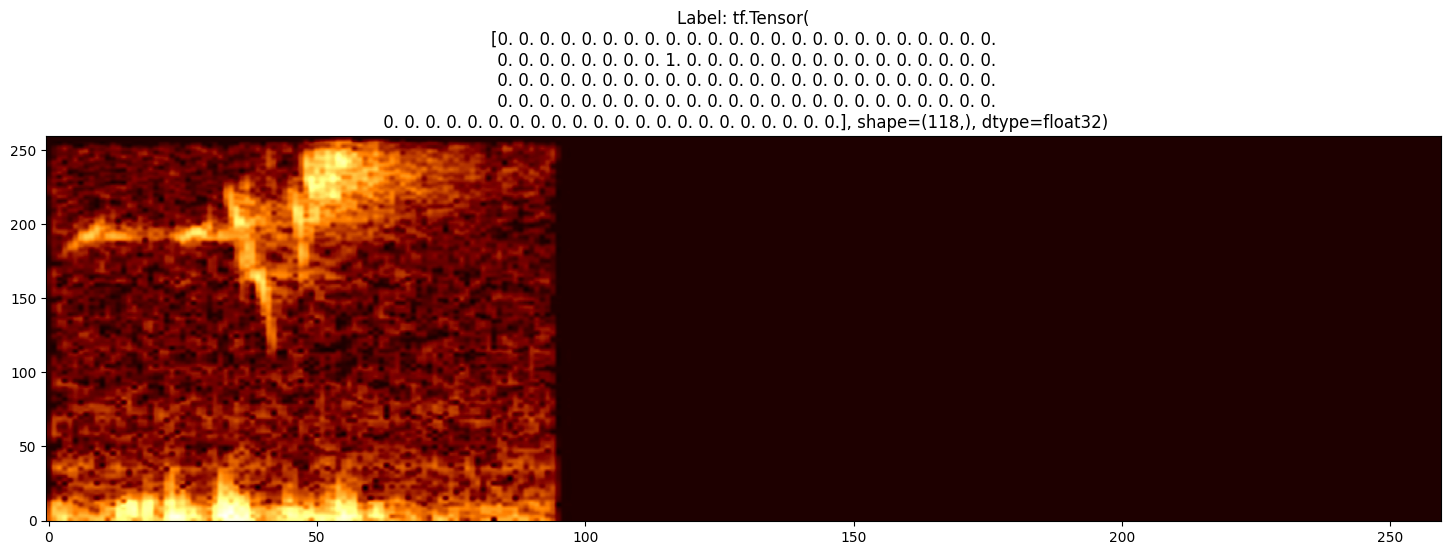

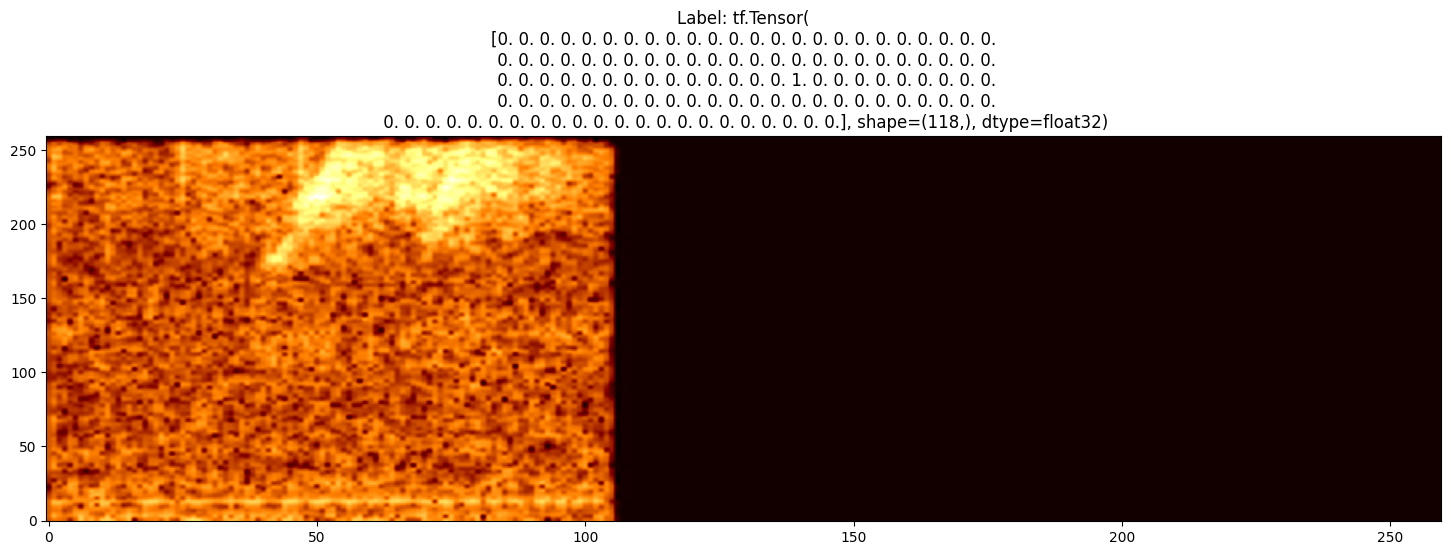

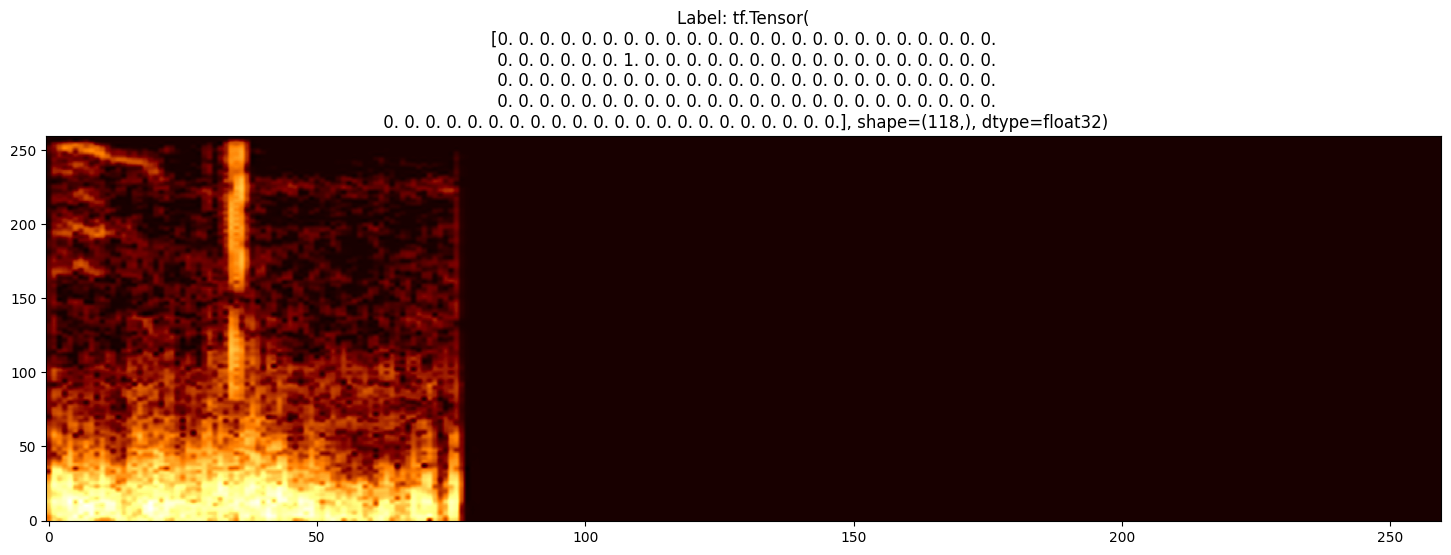

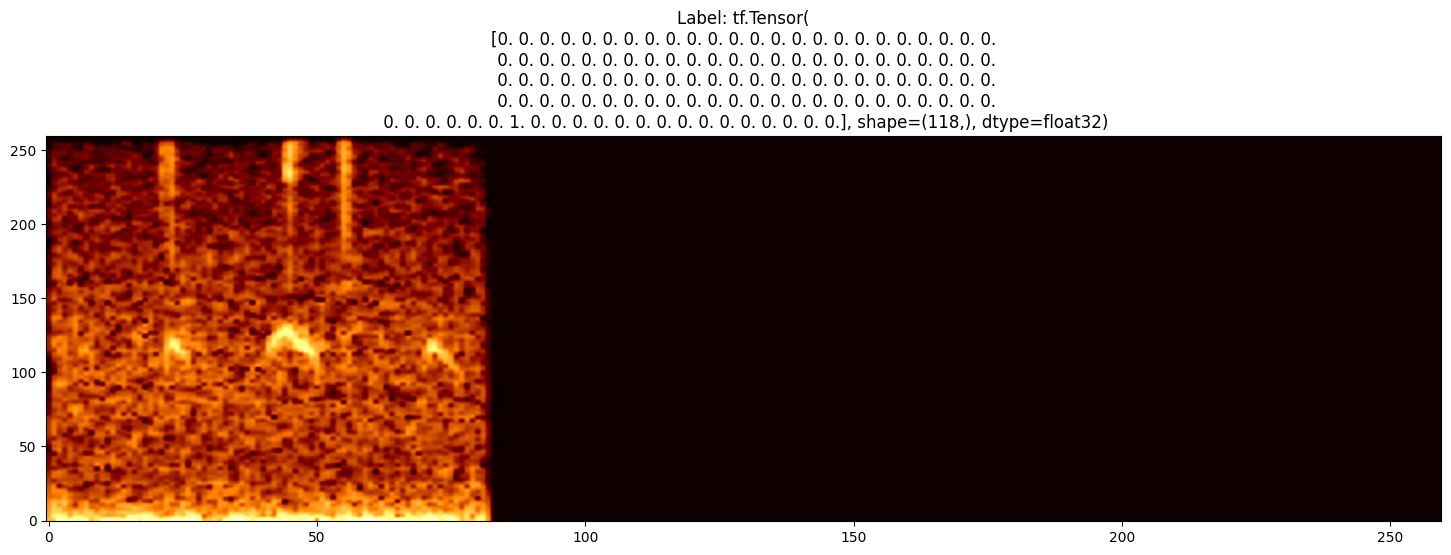

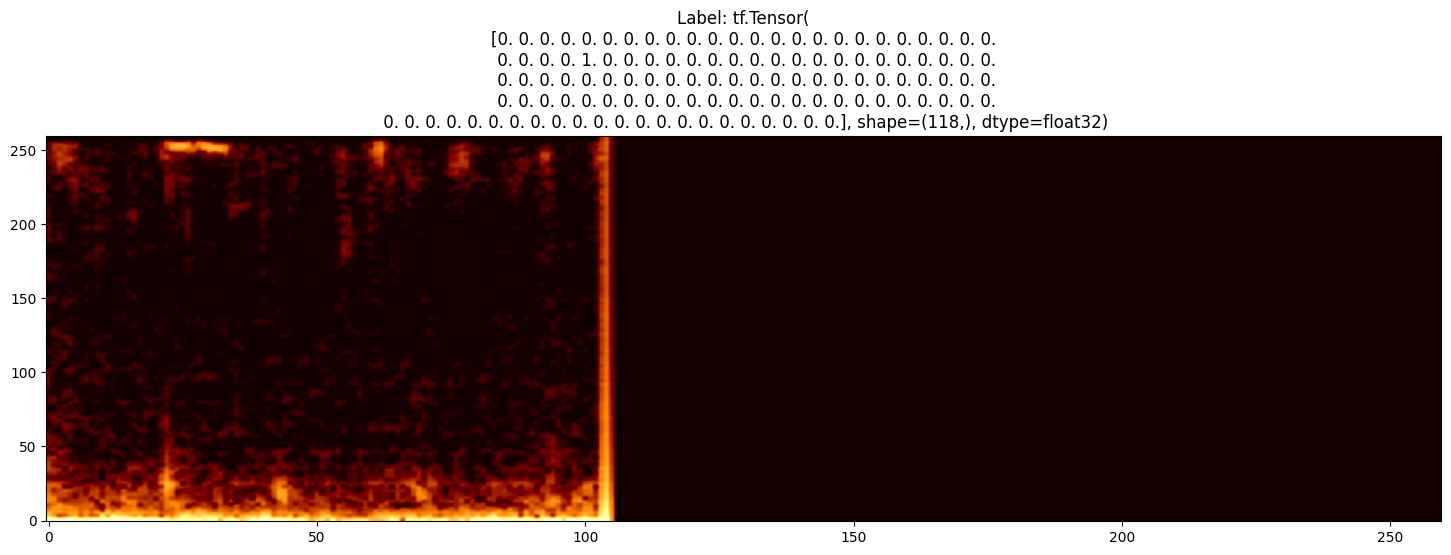

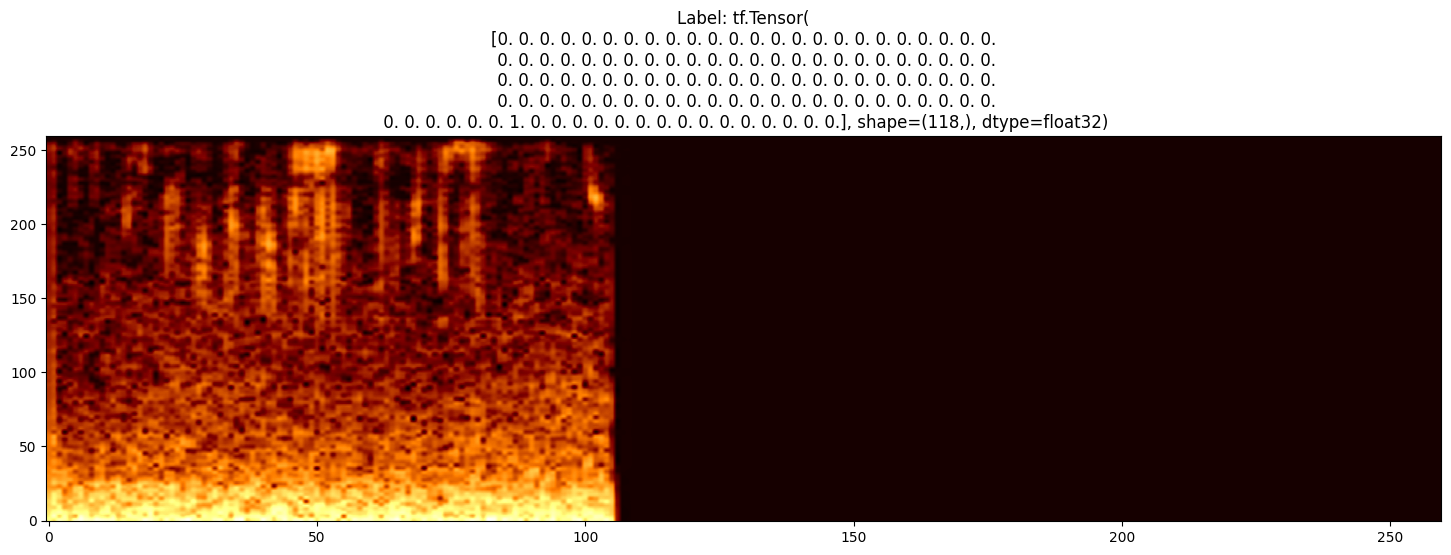

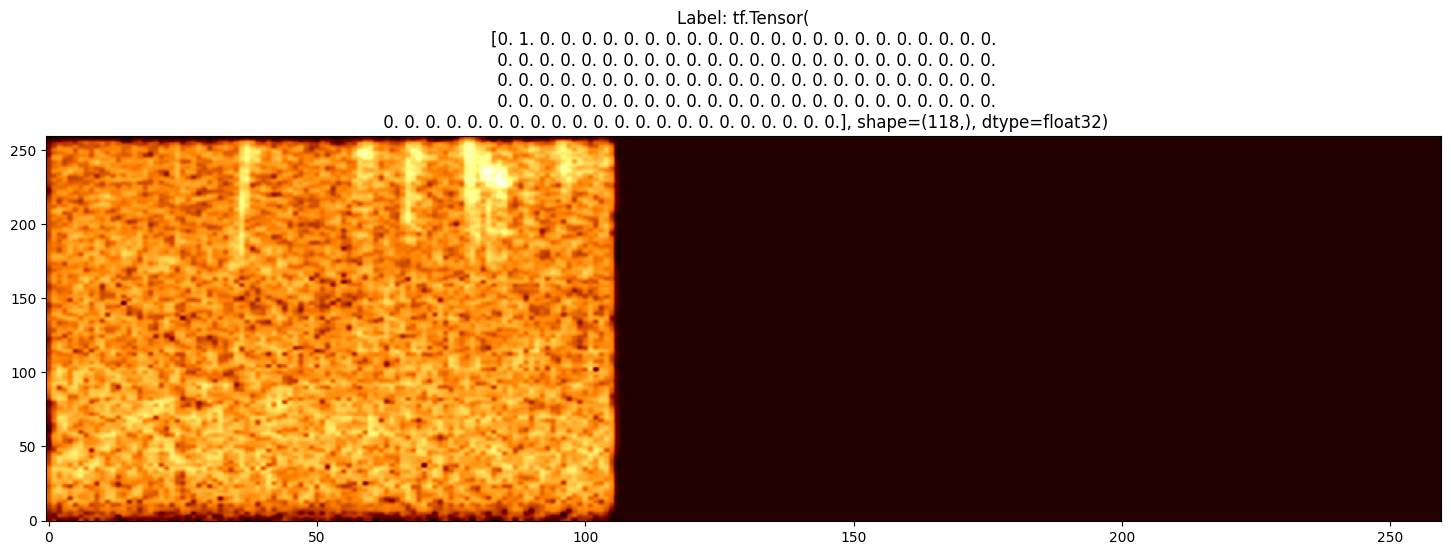

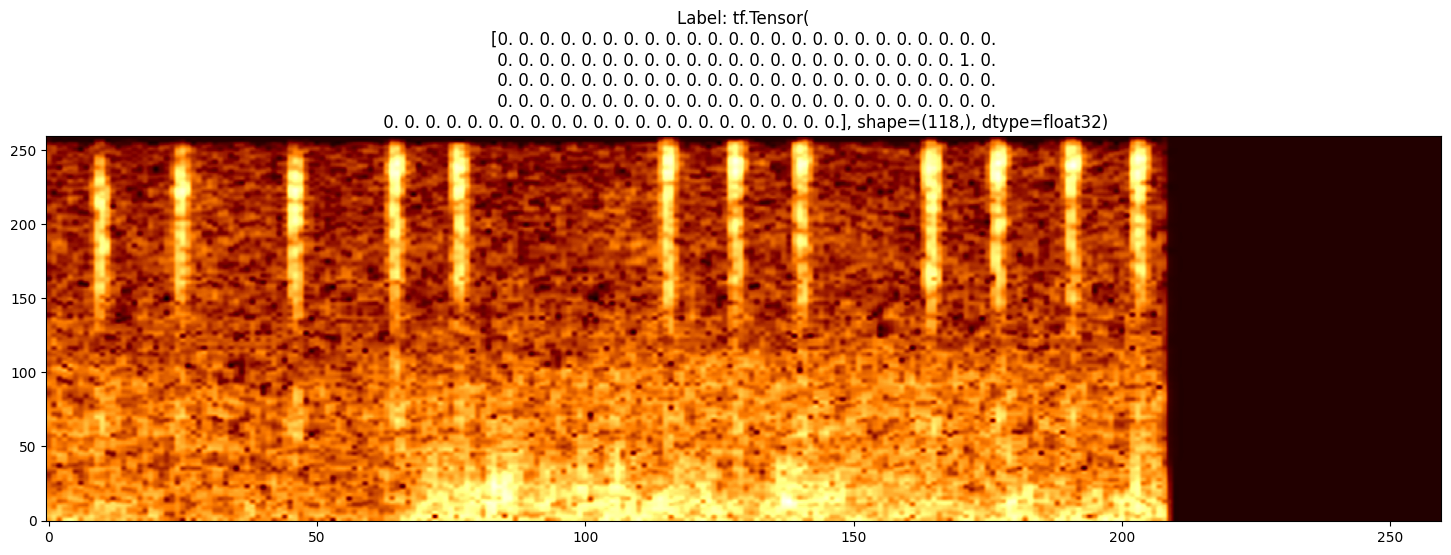

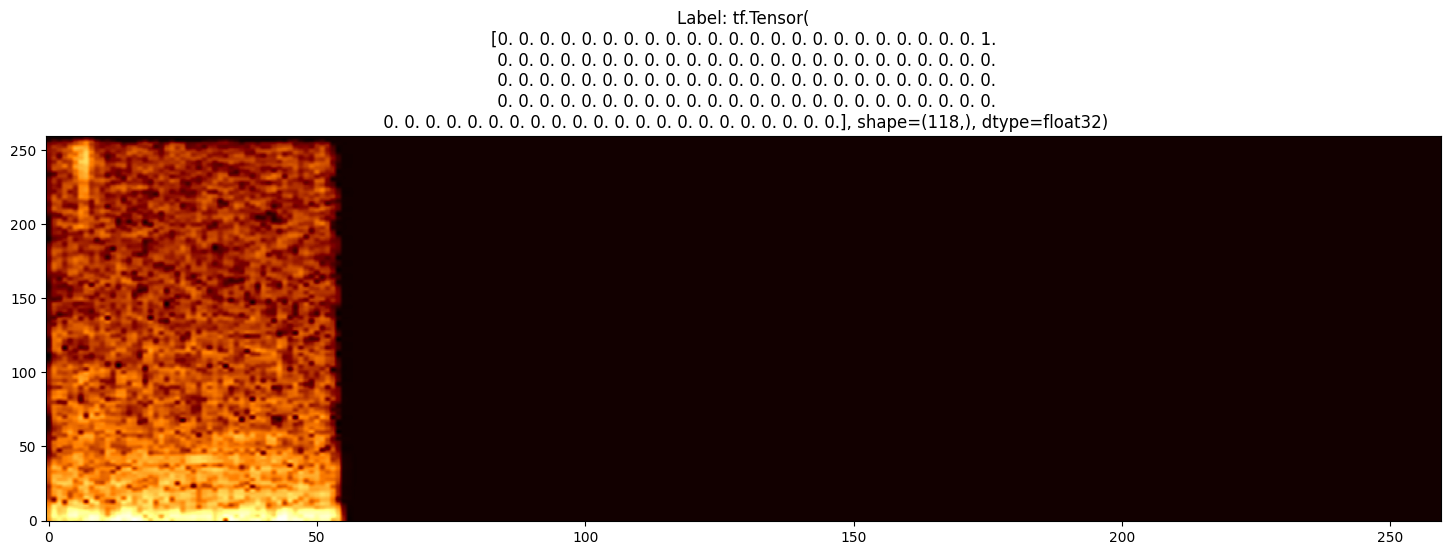

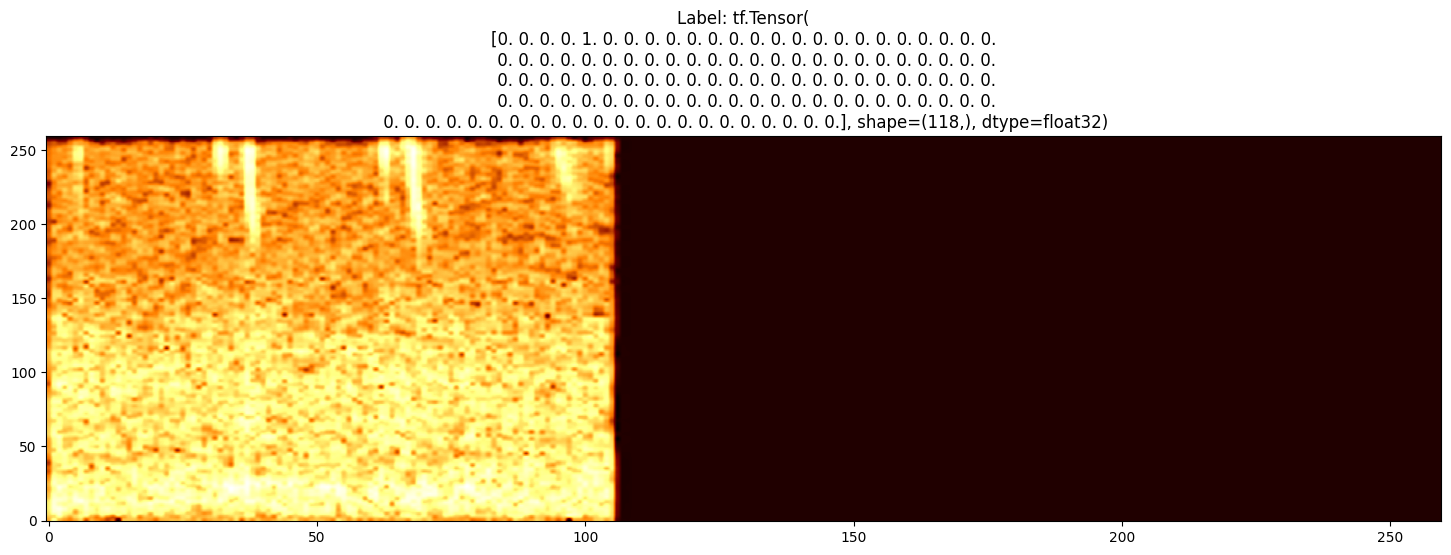

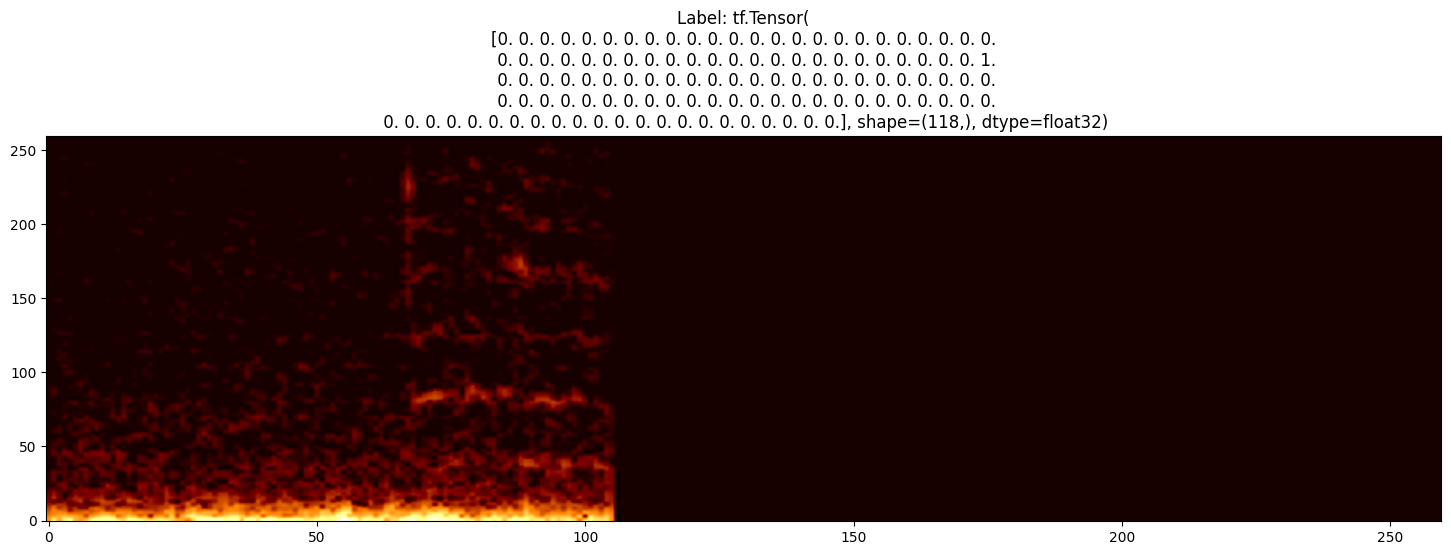

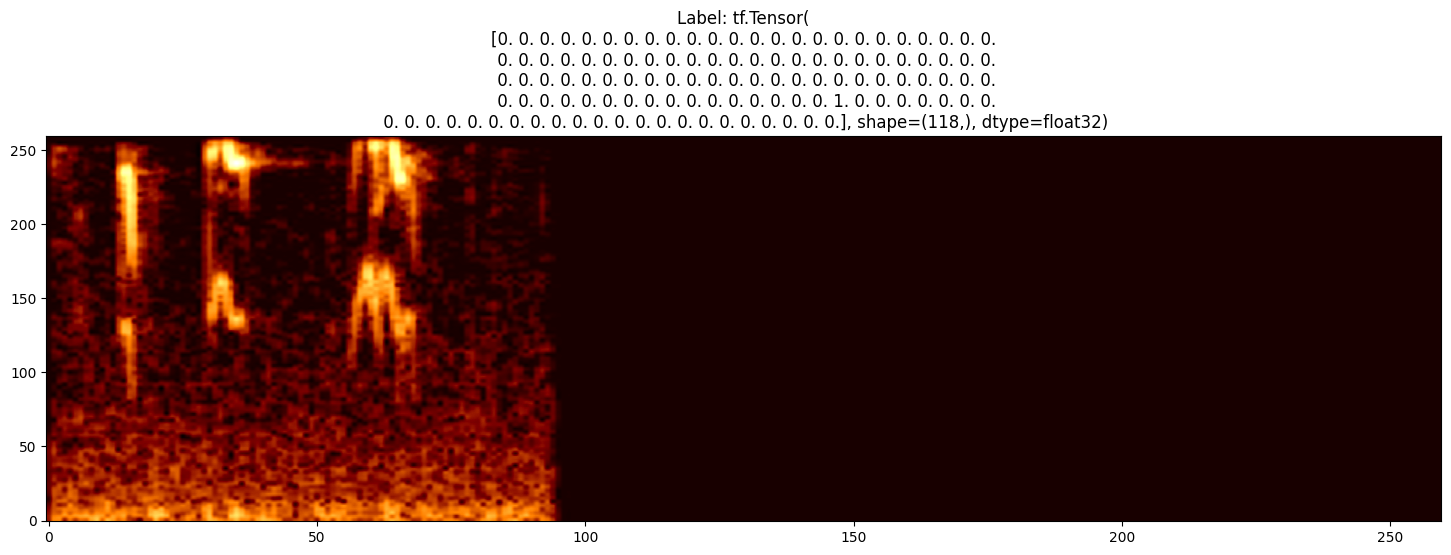

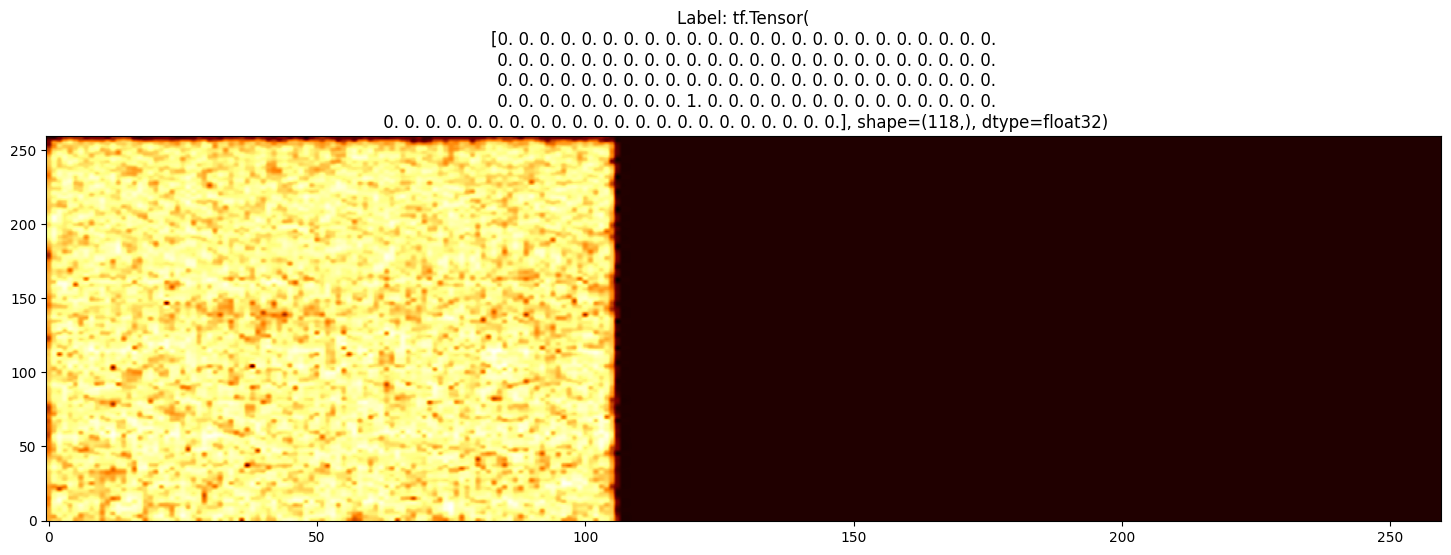

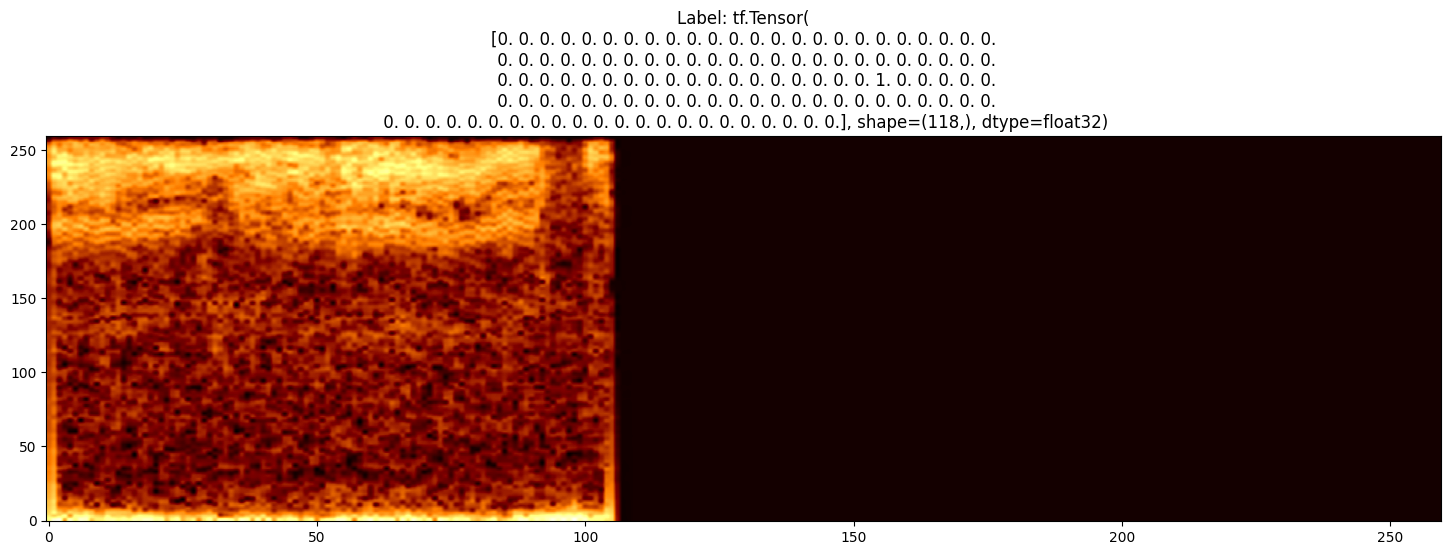

In [141]:
for melspectrogram,label in train4000.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

Make directory to save the model on local device

In [142]:
# only run the code below if want to save the model
if not os.path.exists('C:/Users/regin/Documents/SIT374/models/new_models/4000Hz'):
    os.mkdir('C:/Users/regin/Documents/SIT374/models/new_models/4000Hz') 

## Building the Model
This model leverages pre-trained model weights for the EfficientNetV2 feature model which generates a vector representation of 1000 floats for each input image. The output from the EfficientNetV2 model is then fed into 2 fully connected layers to perform the classification function.

Note: new link to model: https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2

In [143]:
SCM = {
    'MODEL_INPUT_IMAGE_WIDTH': 260,
    'MODEL_INPUT_IMAGE_HEIGHT': 260,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,
    'MAX_EPOCHS': 30
}

In [144]:
import tensorflow_hub as hub

# Custom layer to wrap hub.KerasLayer
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=True):
        super(HubLayer, self).__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

def build_model(trainable):
    # Build a classification model using a pre-trained EfficientNetV2
    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(SCM['MODEL_INPUT_IMAGE_HEIGHT'], 
                                                    SCM['MODEL_INPUT_IMAGE_WIDTH'], 
                                                    SCM['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
            HubLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", trainable),

            # Add the classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(dpp.class_names) * 8,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(dpp.class_names) * 4,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(len(dpp.class_names), activation=None),
        ]
    )
    # Set the input shape for the model
    model.build([None, 
                 SCM['MODEL_INPUT_IMAGE_HEIGHT'],
                 SCM['MODEL_INPUT_IMAGE_WIDTH'], 
                 SCM['MODEL_INPUT_IMAGE_CHANNELS']])

    # Display the model summary
    model.summary()

    return model

In [145]:
import datetime

# allow all the weights to be trained
model4000 = build_model(True)


# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model4000.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=8, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-7)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.keras', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# # any changes to the source code will generally require the disk cache to be cleared.
# # So to be safe, the cache is cleared before training the model.  If you are sure
# # the cache is still valid then comment out this code
# # the first few epochs of the model training will be slow as the cache is populated with pipeline samples
# # and will depend on the dataset size and the number of variants included
# cache.clear()

# fit the model to the training set
# this may take 12-24 hours to run to full model convergence depending on your machine
model4000.fit(train4000, 
          validation_data=val4000,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=SCM['MAX_EPOCHS'])      

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hub_layer_4 (HubLayer)          │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 944)            │     1,209,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 944)            │         3,776 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 472)            │       446,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 472)            │         1,888 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 472)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 118)            │        55,814 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721,902 (6.57 MB)

 Trainable params: 1,716,510 (6.55 MB)

 Non-trainable params: 5,392 (21.06 KB)

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 99s 277ms/step - accuracy: 0.1083 - loss: 5.0816 - val_accuracy: 0.2783 - val_loss: 3.2911 - learning_rate: 1.0000e-04
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 99s 300ms/step - accuracy: 0.3095 - loss: 3.3705 - val_accuracy: 0.4887 - val_loss: 2.2232 - learning_rate: 1.0000e-04
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 94s 284ms/step - accuracy: 0.3740 - loss: 2.8794 - val_accuracy: 0.5626 - val_loss: 1.8635 - learning_rate: 1.0000e-04
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 93s 281ms/step - accuracy: 0.4310 - loss: 2.6147 - val_accuracy: 0.5859 - val_loss: 1.7350 - learning_rate: 1.0000e-04
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 89s 268ms/step - accuracy: 0.4809 - loss: 2.2525 - val_accuracy: 0.6525 - val_loss: 1.4290 - learning_rate: 1.0000e-04
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 88s 266ms/step - accuracy: 0.4894 - loss: 2.1912 - val_accuracy: 0.6651 - val_loss: 1.3530 - learning_rate: 1.0000e-04
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 88s 26

In [146]:
# Save the full model for use with tensorflow serving
model4000.export('C:/Users/regin/Documents/SIT374/models/new_models/4000Hz')

INFO:tensorflow:Assets written to: C:/Users/regin/Documents/SIT374/models/new_models/4000Hz\assets


INFO:tensorflow:Assets written to: C:/Users/regin/Documents/SIT374/models/new_models/4000Hz\assets


Saved artifact at 'C:/Users/regin/Documents/SIT374/models/new_models/4000Hz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 118), dtype=tf.float32, name=None)
Captures:
  2797035597040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035596688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035596336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035594928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035594576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035593168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035592816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035592464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035592112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035593520: TensorSpec(shape=(), dtype=tf.resource, na

## Prediction Using the Model



In [147]:
# Initialize variables to track metrics
true_labels_all4000 = []
predicted_labels_all4000 = []
class_incorrect4000 = defaultdict(int)
class_correct4000 = defaultdict(int)  # Correct predictions per class
class_total4000 = defaultdict(int)  # Total predictions per class


# run predictions
for features, labels in test4000:
    predictions_dict = model4000(features, training=False)
    predictions = model4000.predict(features, verbose=0)

    for batch_idx in range(predictions.shape[0]):
        # Get the true and predicted classes
        true_class = tf.argmax(labels[batch_idx]).numpy()
        predicted_class = int(tf.argmax(predictions[batch_idx]).numpy())

        true_labels_all4000.append(true_class)
        predicted_labels_all4000.append(predicted_class)

        # Update per-class metrics
        class_total4000[true_class] += 1
        if true_class == predicted_class:
            class_correct4000[true_class] += 1
        else:
            class_incorrect4000[true_class] += 1

# Calculate overall accuracy
overall_accuracy4000 = accuracy_score(true_labels_all4000, predicted_labels_all4000)
print(f"Overall Accuracy: {overall_accuracy4000 * 100:.2f}%")

# Print metrics per class
print("\nPrediction Results:")
for idx, class_name in enumerate(dpp.class_names):
    correct = class_correct4000[idx]
    incorrect = class_incorrect4000[idx]
    total = class_total4000[idx]

    print(f"Class: {class_name}")
    print(f"  Total Predictions: {total}")
    print(f"  Correct Predictions: {correct}")
    print(f"  Incorrect Predictions: {incorrect}")
    if total > 0:
        print(f"  Accuracy: {correct / total * 100:.2f}%")
    else:
        print("  No predictions for this class")

# Confusion Matrix
conf_matrix4000 = confusion_matrix(true_labels_all4000, predicted_labels_all4000)



Overall Accuracy: 95.48%

Prediction Results:
Class: Acanthiza chrysorrhoa
  Total Predictions: 3
  Correct Predictions: 2
  Incorrect Predictions: 1
  Accuracy: 66.67%
Class: Acanthiza lineata
  Total Predictions: 1
  Correct Predictions: 1
  Incorrect Predictions: 0
  Accuracy: 100.00%
Class: Acanthiza nana
  Total Predictions: 13
  Correct Predictions: 12
  Incorrect Predictions: 1
  Accuracy: 92.31%
Class: Acanthiza pusilla
  Total Predictions: 24
  Correct Predictions: 23
  Incorrect Predictions: 1
  Accuracy: 95.83%
Class: Acanthiza reguloides
  Total Predictions: 18
  Correct Predictions: 16
  Incorrect Predictions: 2
  Accuracy: 88.89%
Class: Acanthiza uropygialis
  Total Predictions: 11
  Correct Predictions: 11
  Incorrect Predictions: 0
  Accuracy: 100.00%
Class: Acanthorhynchus tenuirostris
  Total Predictions: 10
  Correct Predictions: 8
  Incorrect Predictions: 2
  Accuracy: 80.00%
Class: Accipiter cirrocephalus
  Total Predictions: 10
  Correct Predictions: 9
  Incorrect

We can see that the overall accuracy on a test dataset os 95%, which is considered a high accuracy. Thus training the model on low quality data is possible and does not compromise the accuracy of the model. 